# Polarization Detection using DeBERTa-v3 with Class-Weighted Fine-tuning

## 1. Setup and Dependencies

In [1]:
# Verify GPU
!nvidia-smi

Sun Dec  7 12:18:25 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.172.08             Driver Version: 570.172.08     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Install dependencies
!pip install -q transformers==4.44.0 accelerate scikit-learn pandas numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 70.2 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 82.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.8 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 35.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 15.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    EarlyStoppingCallback
)
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

2025-12-07 12:19:53.427072: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765109993.624468      71 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765109993.675512      71 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

PyTorch version: 2.6.0+cu124
CUDA available: True
Device: Tesla T4


## 2. Configuration

In [4]:
# Configuration
MODEL_NAME = "microsoft/deberta-v3-base"
MAX_LENGTH = 256
BATCH_SIZE = 16
LEARNING_RATE = 2e-5
NUM_EPOCHS = 5
WARMUP_RATIO = 0.1
WEIGHT_DECAY = 0.01
SEED = 42

#set seed for reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)

## 3. Load Data

In [5]:
# Load data
train_df = pd.read_csv('/kaggle/input/sharedtask-polar/subtask1/train/eng.csv')
dev_df = pd.read_csv('/kaggle/input/sharedtask-polar/subtask1/dev/eng.csv')

print(f"Training samples: {len(train_df)}")
print(f"Dev samples: {len(dev_df)}")
print(f"\nLabel distribution in training set:")
print(train_df['polarization'].value_counts())
print(f"\nClass ratio: {train_df['polarization'].value_counts(normalize=True).round(3).to_dict()}")

Training samples: 3222
Dev samples: 160

Label distribution in training set:
polarization
0    2047
1    1175
Name: count, dtype: int64

Class ratio: {0: 0.635, 1: 0.365}


## 4. Text Preprocessing

In [6]:
#preprocessing
import re

def preprocess_text(text):
    """
    Preprocessing pipeline:
    1. remove URLs
    2. normalize whitespace
    3. handle special characters
    """
    # Remove URLs
    text = re.sub(r'http\S+|www\.\S+', '', text)
    # Remove @mentions tapi pertahanin konteks
    text = re.sub(r'@\w+', '', text)
    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

#apply preprocessing
train_df['text_clean'] = train_df['text'].apply(preprocess_text)
dev_df['text_clean'] = dev_df['text'].apply(preprocess_text)

#contoh
print("Original:", train_df['text'].iloc[0])
print("Cleaned:", train_df['text_clean'].iloc[0])

Original:  is defending imperialism in the dnd chat
Cleaned: is defending imperialism in the dnd chat


## 5. Dataset Class and Data Preparation

In [7]:
class PolarizationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [8]:
#split train-val (stratified)
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_df['text_clean'].tolist(),
    train_df['polarization'].tolist(),
    test_size=0.15,
    random_state=SEED,
    stratify=train_df['polarization']
)

print(f"Training samples: {len(train_texts)}")
print(f"Validation samples: {len(val_texts)}")

Training samples: 2738
Validation samples: 484


In [9]:
from sklearn.utils.class_weight import compute_class_weight

#calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=train_labels
)
class_weights = torch.tensor(class_weights, dtype=torch.float32)
print(f"Class weights: {class_weights}")
print(f"  - Non-polarized (0): {class_weights[0]:.4f}")
print(f"  - Polarized (1): {class_weights[1]:.4f}")

Class weights: tensor([0.7868, 1.3717])
  - Non-polarized (0): 0.7868
  - Polarized (1): 1.3717


## 6. Model Setup

In [10]:
#load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2
)

print(f"Model: {MODEL_NAME}")
print(f"Parameters: {model.num_parameters():,}")

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: microsoft/deberta-v3-base
Parameters: 184,423,682


In [11]:
#create datasets
train_dataset = PolarizationDataset(train_texts, train_labels, tokenizer, MAX_LENGTH)
val_dataset = PolarizationDataset(val_texts, val_labels, tokenizer, MAX_LENGTH)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Train dataset size: 2738
Validation dataset size: 484


## 7. Custom Trainer with Class-Weighted Loss

In [12]:
#custom trainer with class weights
class WeightedTrainer(Trainer):
    def __init__(self, class_weights, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights.to(self.args.device)
    
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        
        loss_fn = nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fn(logits, labels)
        
        return (loss, outputs) if return_outputs else loss

In [13]:
#metrics function
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    #itung
    f1_macro = f1_score(labels, predictions, average='macro')
    f1_polarized = f1_score(labels, predictions, average='binary', pos_label=1)
    
    return {
        'f1_macro': f1_macro,
        'f1_polarized': f1_polarized
    }

## 8. Training

In [14]:
#training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=NUM_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    warmup_ratio=WARMUP_RATIO,
    weight_decay=WEIGHT_DECAY,
    learning_rate=LEARNING_RATE,
    logging_dir='./logs',
    logging_steps=50,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='f1_macro',
    greater_is_better=True,
    report_to='none',
    seed=SEED
)

#inisialisasi trainer
trainer = WeightedTrainer(
    class_weights=class_weights,
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

In [15]:
#training
trainer.train()
print("Kelar euy")

Epoch,Training Loss,Validation Loss,F1 Macro,F1 Polarized
1,0.675400,0.452669,0.763221,0.710875
2,0.402500,0.521136,0.801715,0.737805
3,0.267900,0.472289,0.802314,0.769231
4,0.188300,0.586041,0.813481,0.768392
5,0.126200,0.614231,0.822258,0.779292


Kelar euy


## 9. Evaluation and Analysis

In [16]:
#eval val set
eval_results = trainer.evaluate()
print("\nValidation Results:")
for key, value in eval_results.items():
    print(f"  {key}: {value:.4f}")


Validation Results:
  eval_loss: 0.6142
  eval_f1_macro: 0.8223
  eval_f1_polarized: 0.7793
  eval_runtime: 6.0903
  eval_samples_per_second: 79.4710
  eval_steps_per_second: 2.6270
  epoch: 5.0000


In [17]:
#classification report
val_predictions = trainer.predict(val_dataset)
val_preds = np.argmax(val_predictions.predictions, axis=1)

print("\nClassification Report:")
print(classification_report(val_labels, val_preds, target_names=['Non-Polarized', 'Polarized']))


Classification Report:
               precision    recall  f1-score   support

Non-Polarized       0.88      0.85      0.87       307
    Polarized       0.75      0.81      0.78       177

     accuracy                           0.83       484
    macro avg       0.82      0.83      0.82       484
 weighted avg       0.84      0.83      0.83       484



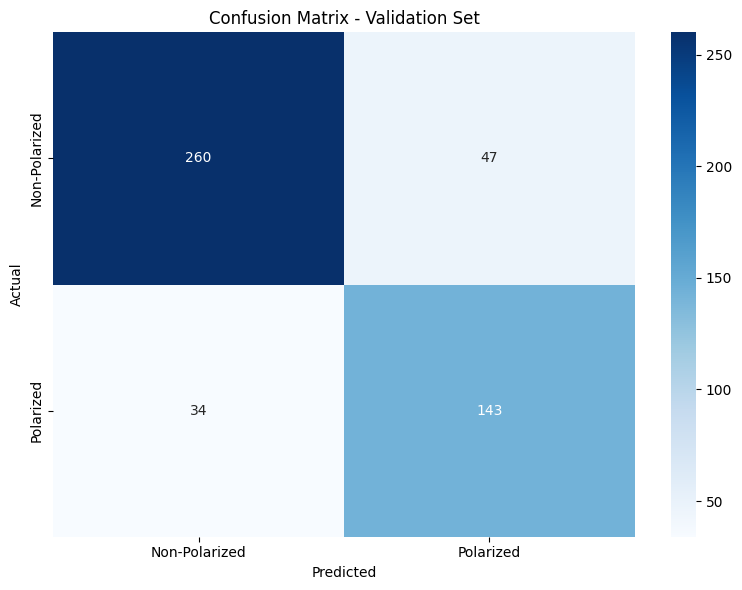


False Positives: 47
False Negatives: 34


In [18]:
#conf mat
cm = confusion_matrix(val_labels, val_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Polarized', 'Polarized'],
            yticklabels=['Non-Polarized', 'Polarized'])
plt.title('Confusion Matrix - Validation Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig('conf_matrix.png', dpi=300)
plt.show()

print(f"\nFalse Positives: {cm[0][1]}")
print(f"False Negatives: {cm[1][0]}")

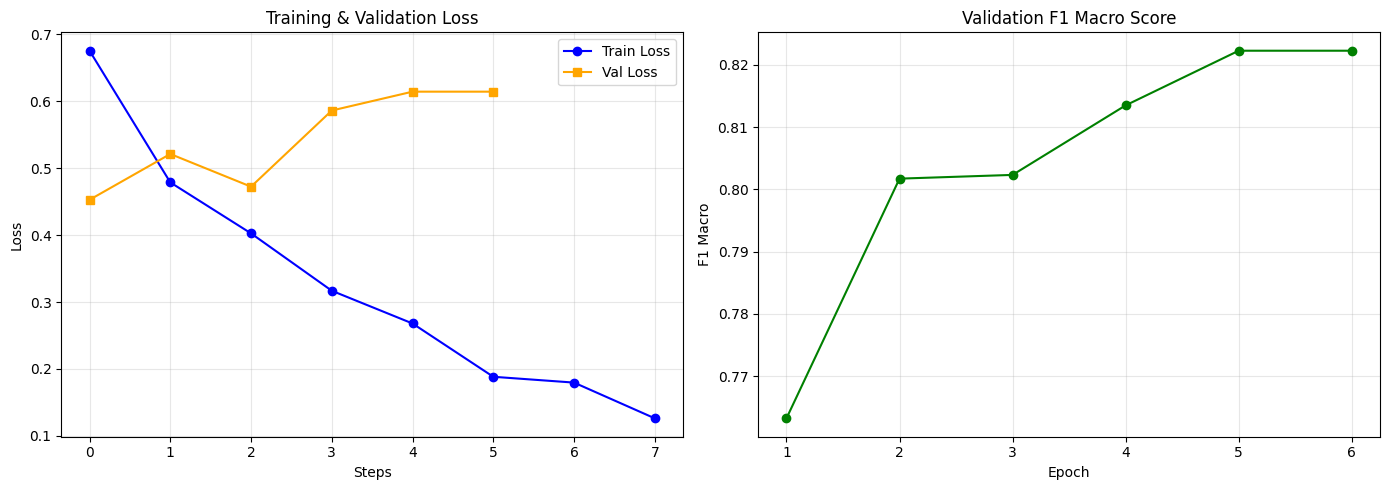

In [19]:
#training history
history = trainer.state.log_history

train_loss = [x['loss'] for x in history if 'loss' in x]
val_loss = [x['eval_loss'] for x in history if 'eval_loss' in x]
val_f1 = [x['eval_f1_macro'] for x in history if 'eval_f1_macro' in x]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

#loss
axes[0].plot(train_loss, 'b-o', label='Train Loss')
axes[0].plot(val_loss, 'orange', marker='s', label='Val Loss')
axes[0].set_xlabel('Steps')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training & Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

#f1-score plot
axes[1].plot(range(1, len(val_f1)+1), val_f1, 'g-o')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('F1 Macro')
axes[1].set_title('Validation F1 Macro Score')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300)
plt.show()

## 10. Error Analysis

In [20]:
#create df-eror analisis
error_df = pd.DataFrame({
    'text': val_texts,
    'true_label': val_labels,
    'pred_label': val_preds.tolist(),
    'correct': [1 if t == p else 0 for t, p in zip(val_labels, val_preds)]
})

#itung
total_errors = len(error_df[error_df['correct'] == 0])
false_positives = len(error_df[(error_df['true_label'] == 0) & (error_df['pred_label'] == 1)])
false_negatives = len(error_df[(error_df['true_label'] == 1) & (error_df['pred_label'] == 0)])

print(f"Total Errors: {total_errors}")
print(f"False Positives (Non-Pol → Pol): {false_positives}")
print(f"False Negatives (Pol → Non-Pol): {false_negatives}")

Total Errors: 81
False Positives (Non-Pol → Pol): 47
False Negatives (Pol → Non-Pol): 34


In [21]:
#show example fp
print("=" * 80)
print("FALSE POSITIVES (0 tapi di prediksi 1)")
print("=" * 80)

fp_df = error_df[(error_df['true_label'] == 0) & (error_df['pred_label'] == 1)]
for idx, row in fp_df.head(5).iterrows():
    print(f"\nText: {row['text'][:200]}...")
    print(f"True: Non-Polarized | Pred: Polarized")
    print("-" * 40)

FALSE POSITIVES (0 tapi di prediksi 1)

Text: Stop ethnic cleansing, speak up fo Hazara genocide. StopHazaraGenocide...
True: Non-Polarized | Pred: Polarized
----------------------------------------

Text: Because he hasnt been charge with insurrection DUH...
True: Non-Polarized | Pred: Polarized
----------------------------------------

Text: MAGA Republicans vs MAGA Democrats Microsoft Amazon Google Apple...
True: Non-Polarized | Pred: Polarized
----------------------------------------

Text: It means expelling asylum seekers. SMH...
True: Non-Polarized | Pred: Polarized
----------------------------------------

Text: Ulysses group promote white nationalism at MU...
True: Non-Polarized | Pred: Polarized
----------------------------------------


In [22]:
#show ex fn
print("=" * 80)
print("FALSE NEGATIVES (1 tapi di prediksi 0)")
print("=" * 80)

fn_df = error_df[(error_df['true_label'] == 1) & (error_df['pred_label'] == 0)]
for idx, row in fn_df.head(5).iterrows():
    print(f"\nText: {row['text'][:200]}...")
    print(f"True: Polarized | Pred: Non-Polarized")
    print("-" * 40)

FALSE NEGATIVES (1 tapi di prediksi 0)

Text: The only sober person around this debate of illegal immigration is...
True: Polarized | Pred: Non-Polarized
----------------------------------------

Text: Time for Ukraine to receive the Iron Dome. Now....
True: Polarized | Pred: Non-Polarized
----------------------------------------

Text: "People need to know what this war really looks like" Israeli soldiers who served in Gaza describe indiscriminate killing and the routine classification of civilian casualties as terrorists in convers...
True: Polarized | Pred: Non-Polarized
----------------------------------------

Text: I think "deal with it" is literally what the second amendment is about. Do I misunderstand?...
True: Polarized | Pred: Non-Polarized
----------------------------------------

Text: For services to War crimes...
True: Polarized | Pred: Non-Polarized
----------------------------------------


In [23]:
# #save csv
# error_df.to_csv('error_analysis.csv', index=False)
# print(f"Error analysis saved to error_analysis.csv")
# print(f"Total samples: {len(error_df)}")
# print(f"Correct: {len(error_df[error_df['correct'] == 1])}")
# print(f"Incorrect: {len(error_df[error_df['correct'] == 0])}")

## 11. Generate Submission

In [24]:
#dev set
dev_texts = dev_df['text'].apply(preprocess_text).tolist()
dev_dataset = PolarizationDataset(dev_texts, [0]*len(dev_texts), tokenizer, MAX_LENGTH)

print(f"Dev set size: {len(dev_dataset)}")

Dev set size: 160


In [25]:
#generate predictions
predictions = trainer.predict(dev_dataset)
preds = np.argmax(predictions.predictions, axis=1)

print(f"Predictions generated: {len(preds)}")
print(f"Distribution: Non-Polarized={np.sum(preds==0)}, Polarized={np.sum(preds==1)}")

Predictions generated: 160
Distribution: Non-Polarized=102, Polarized=58


In [26]:
#submission file
import os

os.makedirs('subtask_1', exist_ok=True)

submission_df = pd.DataFrame({
    'id': dev_df['id'],
    'label': preds
})
submission_df.to_csv('subtask_1/en.csv', index=False)

print("Submission file created!")
print(submission_df.head())

Submission file created!
                                     id  label
0  eng_f66ca14d60851371f9720aaf4ccd9b58      0
1  eng_3a489aa7fed9726aa8d3d4fe74c57efb      0
2  eng_95770ff547ea5e48b0be00f385986483      0
3  eng_2048ae6f9aa261c48e6d777bcc5b38bf      0
4  eng_07781aa88e61e7c0a996abd1e5ea3a20      0


In [27]:
# Create zip for submission
!zip -r submission.zip subtask_1/
print("\nSubmission zip created!")

  adding: subtask_1/ (stored 0%)
  adding: subtask_1/en.csv (deflated 48%)

Submission zip created!


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [28]:
#save model (kalo perlu)
# trainer.save_model('./final_model')
# tokenizer.save_pretrained('./final_model')
# print("Model saved to ./final_model")